# Ivy Individual Project

Dataset URL: http://www.kaggle.com/c/job-salary-prediction

## Libraries

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords

In [2]:
train_data = pd.read_csv("Train_rev1.csv")
selected_data = train_data.sample(n=2500, random_state=42) # randomly select 2500 data points

# selected_data.to_csv("selected_salary_data.csv"bb, index=False) ## Save to new data file to prevent using the big data every time

In [5]:
data = pd.read_csv("selected_salary_data.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Id                  2500 non-null   int64 
 1   Title               2500 non-null   object
 2   FullDescription     2500 non-null   object
 3   LocationRaw         2500 non-null   object
 4   LocationNormalized  2500 non-null   object
 5   ContractType        685 non-null    object
 6   ContractTime        1859 non-null   object
 7   Company             2157 non-null   object
 8   Category            2500 non-null   object
 9   SalaryRaw           2500 non-null   object
 10  SalaryNormalized    2500 non-null   int64 
 11  SourceName          2500 non-null   object
dtypes: int64(2), object(10)
memory usage: 234.5+ KB


In [4]:
data.head(5)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,68062598,Business Account Manager,Business Account Manager Plumbing Heating Pro...,South West,South West London,NaN,permanent,BMS Sales Specialists,Sales Jobs,"22000 - 25000 per annum + Car,Mobile,Pension,L...",23500,totaljobs.com
1,69622111,Staff Nurse RGN/RMN Newtown Abbey Nights Ne...,Job Title; Staff Nurse RGN/RMN – NightsLocatio...,Newtownabbey,Newtownabbey,full_time,NaN,Regional Recruitment Services,Healthcare & Nursing Jobs,12.00/Hour,23040,staffnurse.com
2,66664026,Community Fundraising Manager,This dynamic international development charity...,London,London,full_time,permanent,TPP Not for Profit,Charity & Voluntary Jobs,33300 - 36400 per annum,34850,Third Sector Jobs
3,71015241,Conveyancing Executive,Large regional law firm require a residential ...,Hampshire,Hampshire,full_time,permanent,PTP Consulting,Legal Jobs,"From 18,000 to 27,000 per year",22500,TotallyLegal
4,71428553,Investment Compliance Analyst,This individual will work closely with the bus...,London South East,South East London,NaN,permanent,Michael Page Financial Services,Accounting & Finance Jobs,50000 to 60000 per annum,55000,totaljobs.com


In [6]:
data.describe()

,Id,SalaryNormalized
count,2.500000e+03,2500.000000
mean,6.973466e+07,33764.077200
std,2.976468e+06,16670.019292
min,2.957032e+07,5088.000000
25%,6.869990e+07,21500.000000
50%,6.993177e+07,30000.000000
75%,7.160582e+07,42500.000000
max,7.270293e+07,100000.000000


## EDA & Preprocess

### Categorical Variables

In [18]:
unique_location = data['LocationNormalized'].nunique()
unique_source = data['SourceName'].nunique()

location = data['LocationNormalized'].value_counts()
contract_type = data['ContractType'].value_counts()
contract_time = data['ContractTime'].value_counts()
source = data['SourceName'].value_counts()

print('Number of Unique Location:', unique_location, ', Location Category (Top 5):')
print(location.head(5))
print('-----------------------')
print('Contract Type Category:')
print(contract_type)
print('-----------------------')
print('Contract Time Category:')
print(contract_time)
print('-----------------------')
print('Number of Unique Source:', unique_source, ', Source Category (Top 5):')
print(source.head(5))

Number of Unique Location: 493 , Location Category (Top 5):
LocationNormalized
UK                   452
London               295
South East London    104
The City              67
Manchester            39
Name: count, dtype: int64
-----------------------
Contract Type Category:
ContractType
full_time    603
part_time     82
Name: count, dtype: int64
-----------------------
Contract Time Category:
ContractTime
permanent    1585
contract      274
Name: count, dtype: int64
-----------------------
Number of Unique Source: 125 , Source Category (Top 5):
SourceName
totaljobs.com       487
cv-library.co.uk    353
Jobcentre Plus      190
jobsite.co.uk       119
cwjobs.co.uk         72
Name: count, dtype: int64


### Missing Values

In [21]:
missing_value = data.isna().sum()
print('Missing values:')
print(missing_value)

Missing values:
Id                       0
Title                    0
FullDescription          0
LocationRaw              0
LocationNormalized       0
ContractType          1815
ContractTime           641
Company                343
Category                 0
SalaryRaw                0
SalaryNormalized         0
SourceName               0
dtype: int64


In [72]:
data.fillna('', inplace=True)
missing_value = data.isna().sum()
print('Missing values:')
print(missing_value)

Missing values:
Id                    0
Title                 0
FullDescription       0
LocationRaw           0
LocationNormalized    0
ContractType          0
ContractTime          0
Company               0
Category              0
SalaryRaw             0
SalaryNormalized      0
SourceName            0
dtype: int64


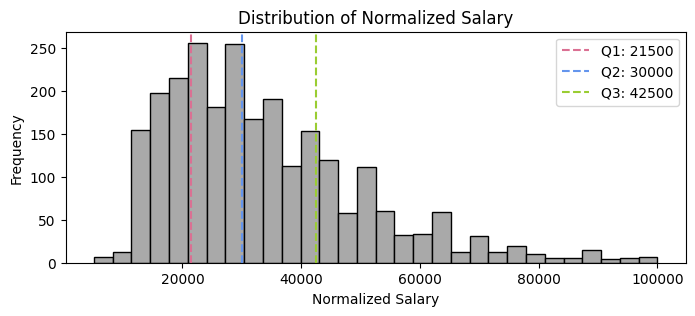

In [73]:
Q1 = data['SalaryNormalized'].quantile(0.25)
Q2 = data['SalaryNormalized'].quantile(0.5)
Q3 = data['SalaryNormalized'].quantile(0.75)

plt.figure(figsize=(8, 3))
plt.hist(data['SalaryNormalized'], bins=30, color='darkgrey', edgecolor='black')
plt.title('Distribution of Normalized Salary')
plt.xlabel('Normalized Salary')
plt.ylabel('Frequency')

plt.axvline(x=Q1, color='palevioletred', linestyle='--', label='Q1: {}'.format(int(Q1)))
plt.axvline(x=Q2, color='cornflowerblue', linestyle='--', label='Q2: {}'.format(int(Q2)))
plt.axvline(x=Q3, color='yellowgreen', linestyle='--', label='Q3: {}'.format(int(Q3)))

plt.legend()
plt.show()

### Identify high/low salary

In [74]:
process_data = data.copy()

process_data['HighSalary'] = (process_data['SalaryNormalized'] >= Q3).astype(int)

process_data.head(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,HighSalary
0,68062598,Business Account Manager,Business Account Manager Plumbing Heating Pro...,South West,South West London,,permanent,BMS Sales Specialists,Sales Jobs,"22000 - 25000 per annum + Car,Mobile,Pension,L...",23500,totaljobs.com,0
1,69622111,Staff Nurse RGN/RMN Newtown Abbey Nights Ne...,Job Title; Staff Nurse RGN/RMN – NightsLocatio...,Newtownabbey,Newtownabbey,full_time,,Regional Recruitment Services,Healthcare & Nursing Jobs,12.00/Hour,23040,staffnurse.com,0
2,66664026,Community Fundraising Manager,This dynamic international development charity...,London,London,full_time,permanent,TPP Not for Profit,Charity & Voluntary Jobs,33300 - 36400 per annum,34850,Third Sector Jobs,0


### Feature selection

In [83]:
process_data['Text'] = process_data['Title'] + ' ' + process_data['FullDescription'] + ' ' + \
    process_data['LocationNormalized'] + ' ' + process_data['ContractType'] + ' ' + \
    process_data['ContractTime'] + ' ' + process_data['Category'] + ' ' + process_data['SourceName'] 

### Data cleaning

In [ ]:
clean_data = process_data.copy()
stop_words = ['in', 'of', 'at', 'a', 'the']

def pre_process(text):
    
    # lowercase
    text=str(text).lower()

    # remove numbers followed by dot (like, "1.", "2.", etc)
    text=re.sub('[^\s]*[0-9]+[^\s]*', "", text)
    
    #remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)

    #remove urls
    text=re.sub(r'[^\s]*(\.com|www\.|\.co\.uk)[^\s]*', "", text)

    #remove stars
    text=re.sub('[^\s]*[\*]+[^\s]*', "", text)
    
    # correct some misspellings and/or replace some text with others that might be easier to handle
    text=text.replace('do not', "don't")
    
    # remove special characters except spaces, apostrophes and dots
    text=re.sub(r"[^a-zA-Z0-9.']+", ' ', text)
    
    # remove stopwords
    text=[word for word in text.split(' ') if word not in stop_words]
    
    return text

In [ ]:
    # lemmatize
    lmtzr = WordNetLemmatizer()
    text = ' '.join((lmtzr.lemmatize(i)) for i in text)

### Train Test Split

In [79]:
X = clean_data['Text']
y = clean_data['HighSalary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)